In [2]:
 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.applications.resnet50 import preprocess_input

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.python.keras import optimizers


import cv2
import math
from IPython.display import clear_output
%matplotlib inline


import os
print(os.listdir("../input/fire-detection-from-cctv/data/data/img_data"))
print(os.listdir("../input/fire-detection-from-cctv/data/data/video_data/test_videos"))
print(os.listdir("../input"))

print(os.listdir("../input/resnet50"))
print(os.listdir("../input/vgg16"))


['test', 'train']
['test3.mp4', 'test2.mp4', 'test1.mp4']
['fire-detection-from-cctv', 'resnet50', 'vgg16']
['resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'imagenet_class_index.json']
['imagenet_class_index.json', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels.h5']


In [3]:
from fastai.vision import *
path = '../input/fire-detection-from-cctv/data/data/img_data/train/smoke'
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)


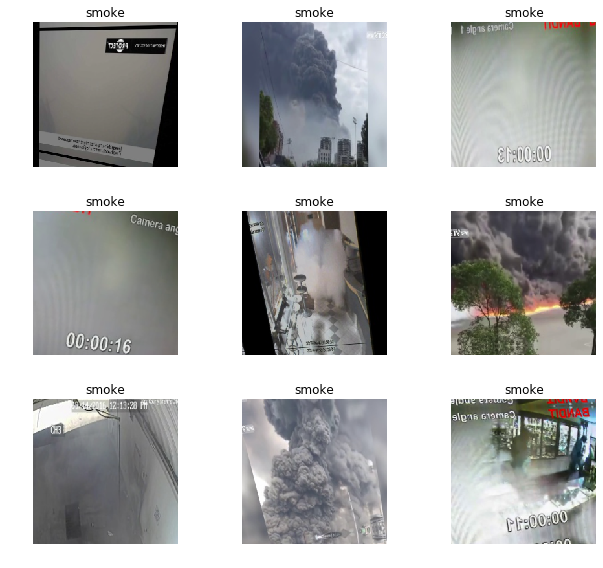

In [4]:
data.show_batch(rows=3, figsize=(9,8),recompute_scale_factor=True)

In [5]:
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 


In [6]:
def create_model( model_size ):
    my_model = Sequential()
    if  model_size == 'L':
        resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        resnet = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path)
       
        my_model.add(resnet)
        my_model.layers[0].trainable = False
    else:
        vgg_weights_path = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg= VGG16(include_top=False, weights=vgg_weights_path ) 
        vgg.summary()
        my_model.add(vgg)
        my_model.add(GlobalAveragePooling2D())
        my_model.layers[0].trainable = False
        my_model.layers[1].trainable = False
        
    my_model.add(Dense(NUM_CLASSES, activation='softmax'))
   
    
    opt = optimizers.adam()
    my_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return my_model

In [7]:
def train_model( model ):
  

    data_generator= ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator.flow_from_directory(
            '../input/fire-detection-from-cctv/data/data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator.flow_from_directory(
            '../input/fire-detection-from-cctv/data/data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
       
    H = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1 
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return model, train_generator,validation_generator

In [8]:
def get_label_dict(train_generator ):
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [9]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [10]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n,
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)
    

In [11]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)

    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

    plt.show()
   

In [12]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [13]:
def prepare_image_for_prediction( img):
   
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

In [14]:
model = create_model('L')
print(model)


Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/20
9/9 [==============================] - 114s 13s/step - loss: 1.0145 - acc: 0.5238 - val_loss: 1.7386 - val_acc: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 99s 11s/step - loss: 0.5208 - acc: 0.8326 - val_loss: 2.4960 - val_acc: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 101s 11s/step - loss: 0.3717 - acc: 0.8903 - val_loss: 0.4346 - val_acc: 1.0000
Epoch 4/20
9/9 [==============================] - 101s 11s/step - loss: 0.3144 - acc: 0.8903 - val_loss: 0.7456 - val_acc: 1.0000
Epoch 5/20
9/9 [==============================] - 101s 11s/step - loss: 0.2588 - acc: 0.9120 - val_loss: 0.8910 - val_acc: 1.0000
Epoch 6/20
9/9 [==============================] - 101s 11s/step - loss: 0.2245 - acc: 0.9293 - val_loss: 1.1979 - val_acc: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 110s 12s/step - loss: 0.1916 - acc: 0.9408 - val_loss: 0.9707 - val_acc: 0.00

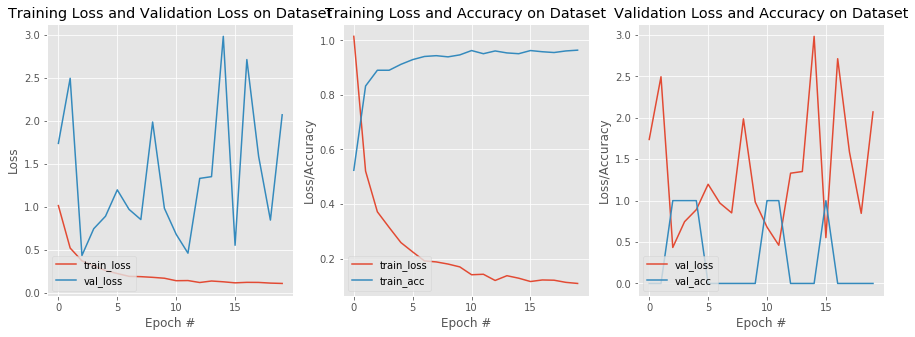

In [37]:
trained_model_l, train_generator,validation_generator = train_model(model)
label_dict_l = get_label_dict(train_generator )

In [40]:
model = create_model('S')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
trained_model_s, train_generator,validation_generator = train_model(model)
label_dict_s = get_label_dict(train_generator)

In [41]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
  
    return txt

In [42]:

def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
       
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)       
            frame = draw_prediction( frame, txt )
      
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
            
        
        writer.write(frame)
        
    vs.release()
    writer.release()
      
   

In [43]:
video_path = '../input/fire-detection-from-cctv/data/data/video_data/test_videos/test1.mp4'
predict ( trained_model_l, video_path, 'test1_9.avi',  label_dict_l) 

video_path = '../input/fire-detection-from-cctv/data/data/video_data/test_videos/test2.mp4'
predict ( trained_model_l, video_path, 'test2_9.avi',  label_dict_l) 

video_path = '../input/fire-detection-from-cctv/data/data/video_data/test_videos/test3.mp4'
predict ( trained_model_l, video_path, 'test3_9.avi',  label_dict_l) 

In [44]:
from IPython.display import YouTubeVideo
YouTubeVideo('cHlTG6WL0OY', width=800, height=450)


In [45]:
from IPython.display import YouTubeVideo
YouTubeVideo('Lk7_qDy60CI', width=800, height=450)


In [46]:
from IPython.display import YouTubeVideo
YouTubeVideo('DtWQiDlnPuU', width=800, height=450)
